# Sprint 3

## Intro

### Idea 1 (Tim)
>> explain 



In [ ]:
# code Tim

### Idea 2 and why this
tekst + company = product
- neural netw
- productie
- Can you find complaints that are assigned to the wrong category? 

## Data (Lennart)

> todo

In [2]:
# downloads and installs
import sys

!conda install --yes --prefix {sys.prefix} nltk bs4 gensim
import nltk
nltk.download('stopwords')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import re
import string
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer

import multiprocessing
from gensim.sklearn_api import D2VTransformer

from sklearn.model_selection import train_test_split

In [5]:
complaints = pd.read_csv('complaints-2020-01-22_08_24.csv')

## EDA (Lennart)

We already did some EDA in sprint 1. In this sprint, we try to classify an email by issue. Here we summarize some of the findings relevant for this usecase.

### Looking at issues

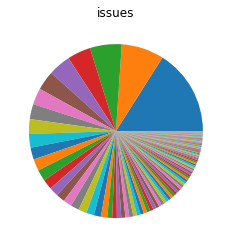

In [6]:
issues = complaints["Issue"].value_counts()
patches = plt.pie(issues.values)
plt.title("issues")
print()

# issues = complaints["Issue"].value_counts()
# patches, texts, autotexts = plt.pie(issues.values, labels = issues.index, radius = 2, autopct="%.1f%%",)
# for t in autotexts:
#     t.set_fontsize(12)
# plt.show()

We can see that the issue occurance is not balanced at all. If we want to use the issues as training data, it will have to balanced.

## PreProcessing (Lennart)

handmatig
> Hoe met tensorflow? (TIM)

In [7]:
# Basic constants
SAMPLE_AMOUNT = 50000
VISUAL_AMOUNT = 5000
PRODUCT_AMOUNT = len(set(complaints['Product']))

### Preprocessing by issues
1. removing row with issues that occur less than 5000 times
2. sample everything to 5000

In [8]:
MIN_REQUIRED = 1000
SUBSAMPLE_AMOUNT = 3000

def preprocByIssues(complaints):
    counts = complaints['Issue'].value_counts()
    names = complaints['Issue'].value_counts().index
    keep = [ names[i] for i, issue_count in enumerate(counts) if issue_count > MIN_REQUIRED ]
    preproc = complaints[complaints['Issue'].isin(keep)]
    sampled = []
    for issue_name in keep:
        if len(preproc[preproc['Issue'] == issue_name]) > SUBSAMPLE_AMOUNT:
            sampled.append(preproc[preproc['Issue'] == issue_name].sample(SUBSAMPLE_AMOUNT))
        else:
            sampled.append(preproc[preproc['Issue'] == issue_name].sample(SUBSAMPLE_AMOUNT, replace=True))
    preproc = pd.concat(objs=sampled)
    print(f'{len(keep)} issues in dataset')
    print(keep)
    
    
    issues = preproc["Issue"].value_counts()
    patches, texts, autotexts = plt.pie(issues.values, labels = keep, radius = 2, autopct="%.1f%%",)
    for t in autotexts:
        t.set_fontsize(12)
    plt.show()
    
    return preproc

### Preprocessing by products

In [9]:
def preprocByProducts(complaints):
    # simplifying dataset
    simp_map = {
        'Debt collection' : 'F', 
        'Payday loan' : 'B', 
        'Mortgage' : 'A', 
        'Bank account or service' : 'E', 
        'Consumer Loan' : 'B', 
        'Other financial service' : 'E', 
        'Vehicle loan or lease' : 'B',
        'Payday loan, title loan, or personal loan' : 'B', 
        'Money transfers' : 'E', 
        'Student loan' : 'B', 
        'Virtual currency': 'E', 
        'Credit reporting, credit repair services, or other personal consumer reports' : 'D', 
        'Credit card' : 'C', 
        'Checking or savings account' : 'E', 
        'Prepaid card' : 'C', 
        'Money transfer, virtual currency, or money service' : 'E', 
        'Credit reporting': 'D', 
        'Credit card or prepaid card' : 'C'}

    featureSet = complaints[['Product', 'Consumer complaint narrative', 'Company']].copy()
    featureSet['TARGET'] = featureSet['Product'].map(simp_map)
    for c in ['A', 'B', 'C', 'D', 'E', 'F']:
        if featureSet[featureSet['TARGET'] == c].shape[0] > 50000:
            featureSet = pd.concat(objs=[featureSet[featureSet['TARGET'] == c].sample(n=50000), featureSet[featureSet['TARGET'] != c]])
    targets = len(featureSet['TARGET'].unique())
    
    print(f'{targets} products in dataset')
    
#     products = featureSet["Issue"].value_counts()
#     patches, texts, autotexts = plt.pie(products.values, labels = products.index, radius = 2, autopct="%.1f%%",)
#     for t in autotexts:
#         t.set_fontsize(12)
#     plt.show()
    
    return featureSet

### Sampling

64 issues in dataset
['Incorrect information on your report', "Problem with a credit reporting company's investigation into an existing problem", 'Attempts to collect debt not owed', 'Incorrect information on credit report', 'Improper use of your report', "Cont'd attempts collect debt not owed", 'Loan servicing, payments, escrow account', 'Communication tactics', 'Trouble during payment process', 'Written notification about debt', 'Loan modification,collection,foreclosure', 'False statements or representation', 'Managing an account', 'Dealing with your lender or servicer', 'Struggling to pay mortgage', 'Dealing with my lender or servicer', 'Took or threatened to take negative or legal action', 'Disclosure verification of debt', 'Managing the loan or lease', 'Problem with a purchase shown on your statement', 'Account opening, closing, or management', "Credit reporting company's investigation", 'Other features, terms, or problems', 'Fees or interest', 'Problem when making payments', 'App

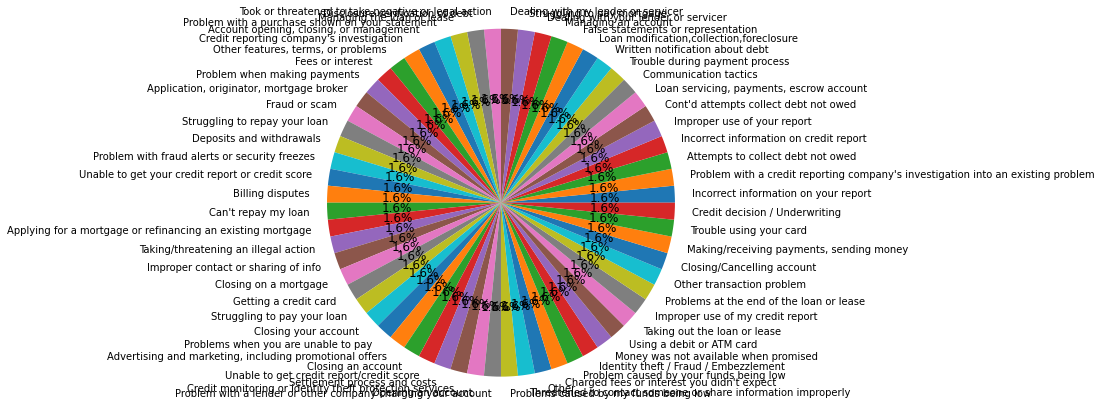

In [10]:
# data = preproc.sample(SAMPLE_AMOUNT, random_state=7844569)
# data = complaints.sample(SAMPLE_AMOUNT, random_state=7844569)
data = preprocByIssues(complaints)

###### Cleaning

In [11]:
def preprocessing(text):
    stopWords = stopWords = set(stopwords.words('english'))
    stemmer = SnowballStemmer("english")
    
    text = BeautifulSoup(text, "html.parser").text
    translator = str.maketrans('', '', string.punctuation) 
    text = text.translate(translator).lower()
    text = re.sub(r'(x)\1+', '', text)
    text = re.sub(r'[0-9]', r' ', text)
    tokens = []
    for word in text.split():
        word = stemmer.stem(word)
        if word not in stopWords:
            tokens.append(word)
    return " ".join(tokens)

In [12]:
data['Consumer complaint narrative'] = data['Consumer complaint narrative'].apply(preprocessing)

### One-Hot encoding company names

In [13]:
companies_1he = pd.get_dummies(data['Company'])

### Feature extraction customer complaint narative

In [14]:
def doc2vec():
    listOfDocsAsListOfStrings = [doc for doc in (row.split() for row in data['Consumer complaint narrative'])]
    model = D2VTransformer(size=250, window=5, min_count=2, workers=multiprocessing.cpu_count())
    transformed = model.fit_transform(listOfDocsAsListOfStrings)
    return transformed

In [15]:
transformed = doc2vec()

In [16]:
print(transformed.shape)
print(companies_1he.shape)
#test = np.concatenate(transformed,companies_1he.to_numpy(), axis=1)
#x = np.append(transformed, companies_1he.to_numpy(),axis=1)
#x.shape

(192000, 250)
(192000, 3365)


### create sets

delegated to model creation to check if different datasets yield better results

In [17]:
def createDataSets(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size= 0.1)

    return x_train,x_val,x_test,y_train,y_val,y_test

targets_1he = pd.get_dummies(data['Product'])


y = targets_1he

# x = to be defined by model

#x = np.append(transformed, companies_1he.to_numpy(),axis=1)
#x = transformed
#x = pd.concat([data['Consumer complaint narrative'], companies_1he], axis=1)
#x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state=0)

## Premade estimator?  OR PoC in KERAS -> Customer Estimator (Roel)

> todo

In [18]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt

In [19]:
def createModel(optimizer,loss, input_shape, output_shape):
    
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(input_shape[1],)))
    model.add(Dense(256, activation='relu'))
    #model.add(Dense(256, activation='relu'))
    model.add(Dense(output_shape[1], activation='softmax'))
    
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) # optimizer='adam'
    return model

def trainModel(model, x, y, batch_size=64, epochs=10):
    x_train,x_val,x_test,y_train,y_val,y_test = createDataSets(x,y)
    
    history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_val, y_val))
    return history, x_test,y_test
    

def validateModel(history, score):
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

Check how good a standard model performs with just the doc2vec set

Epoch 1/10
1890/1890 [==============================] - 4s 2ms/step - loss: 1.4412 - accuracy: 0.5323 - val_loss: 1.1474 - val_accuracy: 0.6038
Epoch 2/10
1890/1890 [==============================] - 5s 3ms/step - loss: 1.1096 - accuracy: 0.6261 - val_loss: 1.0891 - val_accuracy: 0.6282
Epoch 3/10
1890/1890 [==============================] - 5s 3ms/step - loss: 1.0554 - accuracy: 0.6399 - val_loss: 1.0603 - val_accuracy: 0.6346
Epoch 4/10
1890/1890 [==============================] - 5s 2ms/step - loss: 1.0248 - accuracy: 0.6496 - val_loss: 1.0404 - val_accuracy: 0.6385
Epoch 5/10
1890/1890 [==============================] - 5s 2ms/step - loss: 1.0006 - accuracy: 0.6565 - val_loss: 1.0384 - val_accuracy: 0.6462
Epoch 6/10
1890/1890 [==============================] - 5s 2ms/step - loss: 0.9792 - accuracy: 0.6630 - val_loss: 1.0193 - val_accuracy: 0.6480
Epoch 7/10
1890/1890 [==============================] - 5s 2ms/step - loss: 0.9601 - accuracy: 0.6685 - val_loss: 1.0177 - val_accuracy:

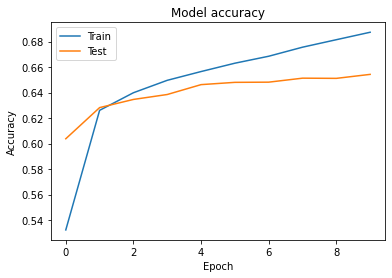

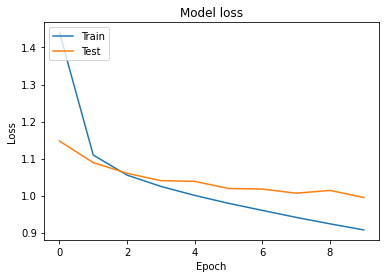

In [20]:
x = transformed

model = createModel(SGD(lr=0.01, momentum=0.9),CategoricalCrossentropy(),x.shape, y.shape)

history,x_test,y_test = trainModel(model,x,y)

score = model.evaluate(x_test, y_test, verbose=0)
validateModel(history,score)

Check how good a standard model performs when adding company names

In [21]:
x = np.append(transformed, companies_1he.to_numpy(),axis=1)
print(x.shape)
print(y.shape)

(192000, 3615)
(192000, 17)


Epoch 1/10
1890/1890 [==============================] - 13s 7ms/step - loss: 1.1946 - accuracy: 0.5906 - val_loss: 0.8966 - val_accuracy: 0.6778
Epoch 2/10
1890/1890 [==============================] - 12s 6ms/step - loss: 0.8538 - accuracy: 0.6886 - val_loss: 0.8304 - val_accuracy: 0.7019
Epoch 3/10
1890/1890 [==============================] - 12s 7ms/step - loss: 0.8051 - accuracy: 0.7043 - val_loss: 0.8085 - val_accuracy: 0.7077
Epoch 4/10
1890/1890 [==============================] - 12s 7ms/step - loss: 0.7744 - accuracy: 0.7140 - val_loss: 0.7925 - val_accuracy: 0.7144
Epoch 5/10
1890/1890 [==============================] - 12s 7ms/step - loss: 0.7502 - accuracy: 0.7199 - val_loss: 0.8003 - val_accuracy: 0.7140
Epoch 6/10
1890/1890 [==============================] - 12s 7ms/step - loss: 0.7310 - accuracy: 0.7261 - val_loss: 0.7725 - val_accuracy: 0.7176
Epoch 7/10
1890/1890 [==============================] - 12s 7ms/step - loss: 0.7095 - accuracy: 0.7344 - val_loss: 0.7604 - val_ac

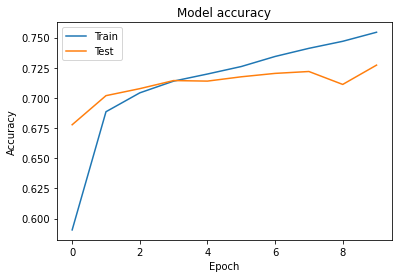

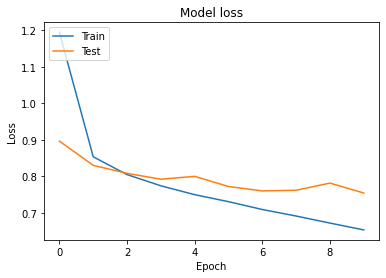

In [22]:
#keras.backend.clear_session()

model = createModel(SGD(lr=0.01, momentum=0.9),CategoricalCrossentropy(),x.shape,y.shape)

history,x_test,y_test = trainModel(model,x,y)
score = model.evaluate(x_test, y_test, verbose=0)

validateModel(history,score)

TODO: add more data / process data differently to see if it has an influence on NN

## Vertalen PoC naar tf.estimator

## In productie (TIM)

> todo

## Can you find complaints that are assigned to the wrong category? (EDA)

> todo